## goal
### - 将sensor按照census tract聚合，每个census tract每天的值取均值代表这个census tract在dateX的值
### - census package - https://pygis.io/docs/d_access_census.html

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import requests

In [3]:
c = Census("59c822f1e8302f7e57bbdd6d0cf1fd7649de1f0e")
API_KEY = '59c822f1e8302f7e57bbdd6d0cf1fd7649de1f0e'

In [5]:
# Assign variable codes and their corresponding labels
profile_vars = ('GEO_ID',
             'NAME', 
             'DP05_0001E', # total population
             'DP05_0002E', # male
             'DP05_0003E', # female
             'DP05_0071E', #  !!Total:!!Hispanic or Latino
             'DP05_0077E', #  !!Total:!!Not Hispanic or Latino:!!Population of one race:!!White alone
             'DP05_0078E', #  !!Total:!!Not Hispanic or Latino:!!Population of one race:!!Black or African American alone
             'DP05_0079E', #  !!Total:!!Not Hispanic or Latino:!!Population of one race:!!American Indian and Alaska Native alone
             'DP05_0080E', #  !!Total:!!Not Hispanic or Latino:!!Population of one race:!!Asian alone
             'DP05_0081E', #  !!Total:!!Not Hispanic or Latino:!!Population of one race:!!Native Hawaiian and Other Pacific Islander alone
             'DP05_0082E', #  !!Total:!!Not Hispanic or Latino:!!Population of one race:!!Some Other Race alone
             'S1101_C01_001E', # Total households
             'S1101_C01_002E', # Average household size
             'S1101_C01_005E', # Estimate!!Total!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years
             'B25034_001E', # total building structures
             'B25034_002E', # Estimate!!Total:!!Built 2014 or later
             'B25034_003E', # Estimate!!Total:!!Built 2010 to 2013
             'B25034_004E', # Estimate!!Total:!!Built 2000 to 2009
             'B25034_005E', # Estimate!!Total:!!Built 1990 to 1999
             'B25034_006E', # Estimate!!Total:!!Built 1980 to 1989
             'B25034_007E', # Estimate!!Total:!!Built 1970 to 1979
             'B25034_008E', # Estimate!!Total:!!Built 1960 to 1969
             'B25034_009E', # Estimate!!Total:!!Built 1950 to 1959
             'B25034_010E', # Estimate!!Total:!!Built 1940 to 1949
             'B25034_011E', # Estimate!!Total:!!Built 1939 or earlier
             'S1501_C01_012E', # Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree
             'DP05_0005E', # Estimate!!SEX AND AGE!!Total population!!Under 5 years
             'DP05_0006E', # Estimate!!SEX AND AGE!!Total population!!5 to 9 years
             'DP05_0007E', # Estimate!!SEX AND AGE!!Total population!!10 to 14 years
             'DP05_0008E', # Estimate!!SEX AND AGE!!Total population!!15 to 19 years
             'DP05_0009E', # Estimate!!SEX AND AGE!!Total population!!20 to 24 years
             'S1901_C01_012E' # Estimate!!Households!!Median income (dollars)
            )
labels =    ('GEOID_str',
             'NAME', 
             'pop_total', 
             'male',
             'female',
             'hispanic',
             'nonH_white', 
             'nonH_black', 
             'nonH_native',
             'nonH_asian', 
             'nonH_pacific',
             'hh_count',
             'hh_avg_size',
             'child_count',
             'building_count',
             'b_2014_',
             'b_2010_2013',
             'b_2000_2009',
             'b_1990_1999',
             'b_1980_1989',
             'b_1970_1979',
             'b_1960_1969',
             'b_1950_1959',
             'b_1940_1949',
             'b__1939',
             'age__5',
             "age_5_9",
             "age_10_14",
             "age_15_19",
             "age_20_24"
            )

In [7]:
# 2021
base = 'https://api.census.gov/data/2021/acs'

state, county = states.CA.fips, '037'
geo = f'for=tract:*&in=state:{state}%20county:{county}&key={API_KEY}'

# Profile
prof_vars = ['GEO_ID','NAME','DP05_0001E','DP05_0002E','DP05_0003E',
             'DP05_0071E','DP05_0077E','DP05_0078E','DP05_0079E',
             'DP05_0080E','DP05_0081E','DP05_0082E', 'DP05_0005E', 'DP05_0006E', 'DP05_0007E', 'DP05_0008E', 'DP05_0009E']
url_prof = f'{base}/acs5/profile?get={",".join(prof_vars)}&{geo}'
r1 = requests.get(url_prof)
print('Profile status:', r1.status_code)      # 应该 200
df_prof_2021 = pd.DataFrame(r1.json()[1:], columns=r1.json()[0])

# Subject
subj_vars = ['GEO_ID','NAME','S1101_C01_001E','S1101_C01_002E','S1101_C01_005E',
             'S1501_C01_012E', 'S1901_C01_012E']
url_subj = f'{base}/acs5/subject?get={",".join(subj_vars)}&{geo}'
r2 = requests.get(url_subj)
print('Subject status:', r2.status_code)
df_subj_2021 = pd.DataFrame(r2.json()[1:], columns=r2.json()[0])

# Detail
det_vars = ['GEO_ID', 'NAME', 'B25034_001E','B25034_002E', 'B25034_003E', 'B25034_004E', 'B25034_005E', 'B25034_006E', 'B25034_007E',\
           'B25034_008E', 'B25034_009E', 'B25034_010E', 'B25034_011E']
url_det = f'{base}/acs5?get={",".join(det_vars)}&{geo}'
r3 = requests.get(url_det)
print('Detail status:', r3.status_code)
df_det_2021 = pd.DataFrame(r3.json()[1:], columns=r3.json()[0])

df_2021 = df_prof_2021.merge(df_subj_2021, on='GEO_ID')\
            .merge(df_det_2021,  on='GEO_ID')

Profile status: 200
Subject status: 200
Detail status: 200


In [8]:
df_2021['state']  = df_2021['state'].astype(str).str.zfill(2)
df_2021['county'] = df_2021['county'].astype(str).str.zfill(3)
df_2021['tract']  = df_2021['tract'].astype(str).str.zfill(6)
df_2021['GEOID']  = df_2021['state'] + df_2021['county'] + df_2021['tract']

# df_2022['state']  = df_2022['state'].astype(str).str.zfill(2)
# df_2022['county'] = df_2022['county'].astype(str).str.zfill(3)
# df_2022['tract']  = df_2022['tract'].astype(str).str.zfill(6)
# df_2022['GEOID']  = df_2022['state'] + df_2022['county'] + df_2022['tract']

df_2021.to_csv('../Data/Output/census_data_extraction_2021.csv')
# df_2022.to_csv('../Data/Output/census_data_extraction_2022.csv')

df_2021.head(1)

,GEO_ID,NAME_x,DP05_0001E,DP05_0002E,DP05_0003E,DP05_0071E,DP05_0077E,DP05_0078E,DP05_0079E,DP05_0080E,...,B25034_006E,B25034_007E,B25034_008E,B25034_009E,B25034_010E,B25034_011E,state,county,tract,GEOID
0,1400000US06037101110,"Census Tract 1011.10, Los Angeles County, Cali...",3879,1944,1935,1005,2305,11,6,405,...,120,118,210,391,198,404,06,037,101110,06037101110


In [9]:
# census tract shapefile
ca_tract = gpd.read_file("../Data/ACS/tl_2021_06_tract/tl_2021_06_tract.shp")

# https://spatialreference.org/ref/epsg/?search=4326
ca_tract = ca_tract.to_crs(epsg = 4326) # EPSG:4326: WGS 84
ca_tract["GEOID_int"] = ca_tract["GEOID"].astype("Int64")
print(ca_tract.head(2))
print('Shape: ', ca_tract.shape)
print("\nThe shapefile projection is: {}".format(ca_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      06      085  504321  06085504321  5043.21  Census Tract 5043.21  G5020   
1      06      085  504410  06085504410  5044.10  Census Tract 5044.10  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1450237       0  +37.3931319  -121.8651427   
1        S  1102136       0  +37.4093719  -121.8788884   

                                            geometry   GEOID_int  
0  POLYGON ((-121.87556 37.39924, -121.87535 37.3...  6085504321  
1  POLYGON ((-121.88886 37.40758, -121.88576 37.4...  6085504410  
Shape:  (9129, 14)

The shapefile projection is: EPSG:4326


In [10]:
ca_tract.iloc[0]

STATEFP                                                     06
COUNTYFP                                                   085
TRACTCE                                                 504321
GEOID                                              06085504321
NAME                                                   5043.21
NAMELSAD                                  Census Tract 5043.21
MTFCC                                                    G5020
FUNCSTAT                                                     S
ALAND                                                  1450237
AWATER                                                       0
INTPTLAT                                           +37.3931319
INTPTLON                                          -121.8651427
geometry     POLYGON ((-121.875559 37.39924, -121.875352 37...
GEOID_int                                           6085504321
Name: 0, dtype: object

# Where are sensors

In [5]:
gdf_pa = gpd.read_file("../Data/Output/PurpleAir_after_Calibration.shp")
df_2021 = pd.read_csv('../Data/Output/census_data_extraction_2021.csv', dtype={'GEOID': str})


gdf_pa['date'] = pd.to_datetime(gdf_pa['date'])
mask = (gdf_pa['date'] >= '2020-12-01') & (gdf_pa['date'] <= '2022-12-01')
gdf_pa = gdf_pa.loc[mask].copy()

# join sensor data with census geoid
gdf_pa = gdf_pa.to_crs(ca_tract.crs)
gdf_pa = gpd.sjoin(gdf_pa, ca_tract[['GEOID','geometry']], how = 'left', predicate = 'within')

KeyboardInterrupt: 

In [ ]:
gdf_pa.columns

In [ ]:
gdf_pa.columns = ['Unnamed_ 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
               'pa_latency', 'humidity_a', 'humidity_b', 'temperatur', 'temperat_1',
               'pressure_a', 'pressure_b', 'voc_a', 'voc_b', 'pm2.5_atm_',
               'pm2.5_at_1', 'pm10.0_atm', 'pm10.0_a_1', 'sensor_ind', 'date_creat',
               'location_t', 'model', 'uptime_y', 'position_r', 'latitude',
               'longitude', 'altitude', 'confidence', 'pm25_avg', 'PA_PM25',
               'PA_RH', 'PA_T', 'PA_PM25cali_025', 'PA_PM25cali_05', 'diff_05',
               'diff_025', 'geometry', 'index_right', 'GEOID']

In [ ]:
'''for 2021，
一年内单日最多有多少传感器同时工作； 
在至少有一个传感器工作的时候，单日最少有多少传感器工作。； 
全年中至少一天有传感器工作的天数。； 
全年平均每天有多少传感器工作（总活跃数/ 周期天数）。
'''
df_2years = gdf_pa.copy()

daily_counts = df_2years.groupby(['GEOID', 'date'])['sensor_id'].nunique().reset_index(name = 'daily_sensors')

period_days_year = (pd.Timestamp('2022-12-31') - pd.Timestamp('2020-12-01')).days + 1

summary_year = daily_counts.groupby('GEOID').agg(
        max_active = ('daily_sensors', 'max'),
        min_active = ('daily_sensors', lambda x: x[x > 0].min()),
        days_with_activity = ('daily_sensors', lambda x: (x > 0).sum()),
        total_active = ('daily_sensors', 'sum')
    ).reset_index()

summary_year['avg_daily_sensors'] = summary_year['total_active'] / period_days_year
summary_year.head()

In [ ]:
df_2021['GEOID']

In [ ]:
summary_year.to_csv("../Data/Output/S5_activeSensorsByCensusTract.csv")

# Covert census features

In [23]:
summary_year = pd.read_csv('../Data/Output/S5_activeSensorsByCensusTract.csv')
df_2021 = pd.read_csv('../Data/Output/census_data_extraction_2021.csv')
merged_summary = summary_year.merge(df_2021, on = 'GEOID', how = 'left') # assume 2021 census characterics for the whole time peroid
merged_summary.head(1)

,Unnamed: 0_x,GEOID,max_active,min_active,days_with_activity,total_active,avg_daily_sensors,Unnamed: 0_y,GEO_ID,NAME_x,...,B25034_005E,B25034_006E,B25034_007E,B25034_008E,B25034_009E,B25034_010E,B25034_011E,state,county,tract
0,0,6037101110,1,1,133,133,0.17477,0.0,1400000US06037101110,"Census Tract 1011.10, Los Angeles County, Cali...",...,112.0,120.0,118.0,210.0,391.0,198.0,404.0,6.0,37.0,101110.0


In [25]:
df_cluster_analysis = merged_summary.copy()
pop = 'DP05_0001E'
df_cluster_analysis['male_rate'] = df_cluster_analysis['DP05_0002E'] / df_cluster_analysis[pop]
df_cluster_analysis['female_rate'] = df_cluster_analysis['DP05_0003E'] / df_cluster_analysis[pop]
df_cluster_analysis['hispanic_rate'] = df_cluster_analysis['DP05_0071E'] / df_cluster_analysis[pop]
df_cluster_analysis['white_rate'] = df_cluster_analysis['DP05_0077E'] / df_cluster_analysis[pop]
df_cluster_analysis['black_rate'] = df_cluster_analysis['DP05_0078E'] / df_cluster_analysis[pop]
df_cluster_analysis['native_american_rate'] = df_cluster_analysis['DP05_0079E'] / df_cluster_analysis[pop]
df_cluster_analysis['asian_rate'] = df_cluster_analysis['DP05_0080E'] / df_cluster_analysis[pop]
df_cluster_analysis['pacific_islander_rate'] = df_cluster_analysis['DP05_0081E'] / df_cluster_analysis[pop]
df_cluster_analysis['other_race_rate'] = df_cluster_analysis['DP05_0082E'] / df_cluster_analysis[pop]
df_cluster_analysis['25_older_rate'] = (df_cluster_analysis['DP05_0001E'] - (df_cluster_analysis['DP05_0005E'] +
                                                                            df_cluster_analysis['DP05_0006E'] +
                                                                            df_cluster_analysis['DP05_0007E'] +
                                                                            df_cluster_analysis['DP05_0008E'] +
                                                                            df_cluster_analysis['DP05_0009E']
                                                                           ))/ df_cluster_analysis['DP05_0001E']
str_total = 'B25034_001E'
pre_1979 = ['B25034_007E','B25034_008E','B25034_009E','B25034_010E','B25034_011E']
grp_1980_2000 = ['B25034_006E','B25034_005E']
grp_after2000 = ['B25034_004E', 'B25034_003E', 'B25034_002E']
all_cols = [str_total] + pre_1979 + grp_1980_2000 + grp_after2000
df_cluster_analysis[all_cols] = df_cluster_analysis[all_cols].apply(lambda col: pd.to_numeric(col, errors = 'coerce')).fillna(0).astype(int)
df_cluster_analysis['pct_built_pre1979'] = df_cluster_analysis[pre_1979].sum(axis = 1) / df_cluster_analysis[str_total]
df_cluster_analysis['pct_built_1980_2000'] = df_cluster_analysis[grp_1980_2000].sum(axis=1) / df_cluster_analysis[str_total]
df_cluster_analysis['pct_built_after2000'] = df_cluster_analysis[grp_after2000].sum(axis=1) / df_cluster_analysis[str_total] * 100

In [27]:
df_cluster_analysis.columns

Index(['Unnamed: 0_x', 'GEOID', 'max_active', 'min_active',
       'days_with_activity', 'total_active', 'avg_daily_sensors',
       'Unnamed: 0_y', 'GEO_ID', 'NAME_x', 'DP05_0001E', 'DP05_0002E',
       'DP05_0003E', 'DP05_0071E', 'DP05_0077E', 'DP05_0078E', 'DP05_0079E',
       'DP05_0080E', 'DP05_0081E', 'DP05_0082E', 'DP05_0005E', 'DP05_0006E',
       'DP05_0007E', 'DP05_0008E', 'DP05_0009E', 'state_x', 'county_x',
       'tract_x', 'NAME_y', 'S1101_C01_001E', 'S1101_C01_002E',
       'S1101_C01_005E', 'S1501_C01_012E', 'S1901_C01_012E', 'state_y',
       'county_y', 'tract_y', 'NAME', 'B25034_001E', 'B25034_002E',
       'B25034_003E', 'B25034_004E', 'B25034_005E', 'B25034_006E',
       'B25034_007E', 'B25034_008E', 'B25034_009E', 'B25034_010E',
       'B25034_011E', 'state', 'county', 'tract', 'male_rate', 'female_rate',
       'hispanic_rate', 'white_rate', 'black_rate', 'native_american_rate',
       'asian_rate', 'pacific_islander_rate', 'other_race_rate',
       '25_older_rat

In [35]:
feature_cols = [
     'GEOID',
     'max_active', 'min_active', 'days_with_activity',
     'total_active', 'avg_daily_sensors',
     'DP05_0001E', # total population
     'male_rate', 'hispanic_rate', 'white_rate', 'black_rate',
     'native_american_rate', 'asian_rate', 'pacific_islander_rate',
     'other_race_rate', '25_older_rate',
     'S1101_C01_001E', # Total households
     'S1101_C01_002E', # Average household size
     'S1101_C01_005E', # Estimate!!Total!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years
     'B25034_001E', # total building structures
     'pct_built_pre1979',
     'pct_built_1980_2000', 'pct_built_after2000',
     'S1501_C01_012E'# Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree
]
sensor_features = df_cluster_analysis[feature_cols]
sensor_features.to_csv('../Data/Output/sensor_features.csv')

In [35]:
sensor_features = pd.read_csv('../Data/Output/sensor_features.csv')
ca_tract = gpd.read_file("../Data/ACS/tl_2021_06_tract/tl_2021_06_tract.shp")
# https://spatialreference.org/ref/epsg/?search=4326
ca_tract = ca_tract.to_crs(epsg = 4326) # EPSG:4326: WGS 84
ca_tract["GEOID"] = ca_tract["GEOID"].astype("Int64")
print(ca_tract.head(2))
print('Shape: ', ca_tract.shape)
print("\nThe shapefile projection is: {}".format(ca_tract.crs))

sensor_features_shp = sensor_features.merge(ca_tract, on = "GEOID", how = "left")
sensor_features_shp = gpd.GeoDataFrame(sensor_features_shp, geometry = "geometry", crs = ca_tract.crs)

  STATEFP COUNTYFP TRACTCE       GEOID     NAME              NAMELSAD  MTFCC  \
0      06      085  504321  6085504321  5043.21  Census Tract 5043.21  G5020   
1      06      085  504410  6085504410  5044.10  Census Tract 5044.10  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1450237       0  +37.3931319  -121.8651427   
1        S  1102136       0  +37.4093719  -121.8788884   

                                            geometry  
0  POLYGON ((-121.87556 37.39924, -121.87535 37.3...  
1  POLYGON ((-121.88886 37.40758, -121.88576 37.4...  
Shape:  (9129, 13)

The shapefile projection is: EPSG:4326


# spatially-constrained clustering
- what type of census tract has more sensors
- https://spatialanalysis.github.io/workshop-notes/spatial-clustering.html

In [37]:
import libpysal
from spopt.region import Skater
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

<Axes: >

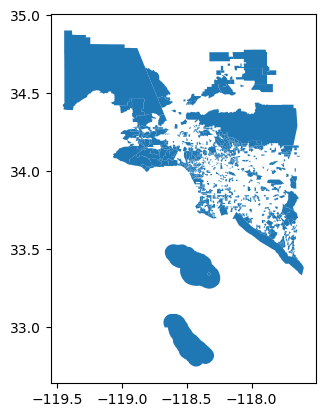

In [42]:
sensor_features_shp.plot()

# cluster sensor data

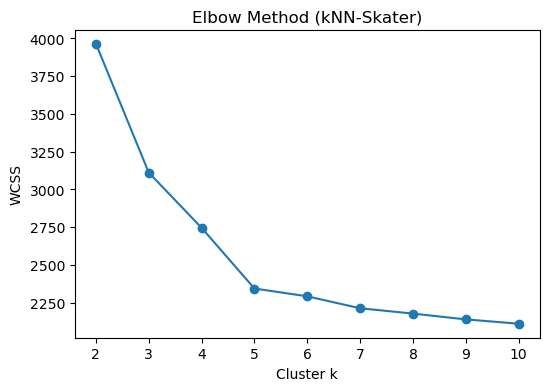

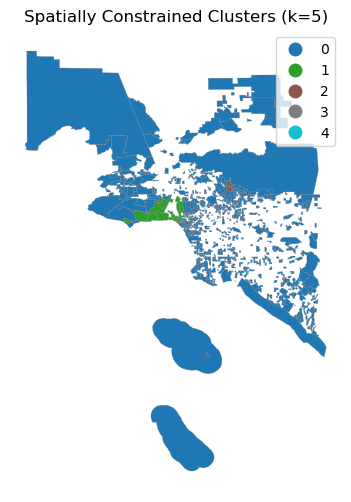

In [51]:
gdf_proj = sensor_features_shp.to_crs(epsg = 4326)
cluster_features = [
    'max_active', 'min_active', 'days_with_activity',
     'total_active', 'avg_daily_sensors'
     ] # --------------------------------------------------- 23 columns
X = gdf_proj[cluster_features].astype(float) # 24

mask = X.notnull().all(axis=1)
gdf_clean = gdf_proj[mask].copy()
X_clean = X[mask]

scaler = StandardScaler()
X_std = scaler.fit_transform(X_clean)
std_cols = [f"{c}_std" for c in cluster_features]
df_std = pd.DataFrame(X_std, columns=std_cols, index=gdf_clean.index)

gdf_std = gdf_clean.join(df_std)

from libpysal.weights import KNN

# W
w = KNN.from_dataframe(gdf_std, k = 5)
w.transform = 'r'

def compute_wcss(gdf, attrs, w, k_range):
    wcss = []
    data_arr = gdf[attrs].values
    for k in k_range:
        model = Skater(
            gdf,
            w,
            attrs, 
            n_clusters=k,
            floor=0.05
        )
        model.solve()
        labels = model.labels_
        # 计算每簇的平方和
        wss_k = 0
        for i in range(k):
            pts = data_arr[labels == i]
            if pts.size:
                cent = pts.mean(axis=0)
                wss_k += ((pts - cent)**2).sum()
        wcss.append(wss_k)
    return wcss

k_range = range(2, 11)
wcss = compute_wcss(gdf_std, std_cols, w, k_range)
plt.figure(figsize = (6,4))
plt.plot(list(k_range), wcss, 'o-')
plt.xlabel('Cluster k')
plt.ylabel('WCSS')
plt.title('Elbow Method (kNN‐Skater)')
plt.show()

n_clusters = 5
model = Skater(
    gdf_std,
    w, 
    std_cols,
    n_clusters = n_clusters,
    floor = 0.05
)
model.solve()

gdf_std['cluster'] = model.labels_

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf_std.plot(
    column = 'cluster',
    categorical = True,
    legend = True,
    linewidth = 0.2,
    edgecolor = 'gray',
    ax = ax
)
ax.set_axis_off()
ax.set_title(f"Spatially Constrained Clusters (k={n_clusters})")
plt.show()

In [52]:
mapping = {
    'max_active': ('Active Sensors', 'Max Active'),
    'min_active': ('Active Sensors', 'Min Active'),
    'days_with_activity': ('Active Sensors',  'Active Days'),
    'avg_daily_sensors':  ('Active Sensors', 'Avg Daily Active Sensors'),
    'DP05_0001E': ('Population', 'count (DP05_0001E)'),
    'male_rate':  ('Gender', 'Male Rate'),
    'hispanic_rate': ('Race/ Ethnicity', 'Hispanic/ Latino'),
    'white_rate':  ('Race/ Ethnicity', 'White'),
    'black_rate': ('Race/ Ethnicity', 'Black Or African American'),
    'native_american_rate': ('Race/ Ethnicity',  'American Indian and Alaska Native'),
    'asian_rate':  ('Race/ Ethnicity', 'Asian'),
    'pacific_islander_rate': ('Race/ Ethnicity',  'Native Hawaiian and Other Pacific Islander'),
    'other_race_rate': ('Race/ Ethnicity', 'Others'),
    '25_older_rate': ('Age', 'Age > 25 (%)'),
    'S1501_C01_012E': ('Poverty', 'Median HH income (S1501_C01_012E)'),
    'pct_built_pre1979': ('Structure Built year', 'Pre 1979 (%)'),
    'pct_built_1980_2000': ('Structure Built year', '1980 - 1999 (%)'),
    'pct_built_after2000': ('Structure Built year', 'Post 2000 (%)'),
}
df = gdf_std[ list(mapping.keys()) + ['cluster'] ]
df_mean = df.groupby('cluster').mean()
df_std  = df.groupby('cluster').std()
df_fmt = df_mean.round(2).astype(str) + ' (' + df_std.round(2).astype(str) + ')'
df_fmt = df_fmt.T
tuples = [ mapping[col] for col in mapping.keys() ]
row_index = pd.MultiIndex.from_tuples(tuples, names=['Category','Variable'])
df_fmt.index = row_index
df_fmt.columns = [f'Cluster {c}' for c in df_fmt.columns]

counts = df['cluster'].value_counts().sort_index()
df_count = counts.to_frame().T
df_count.index = pd.MultiIndex.from_tuples(
    [('Tract', 'Number of tracts')],
    names=['Category','Variable']
)
df_count.columns = [f'Cluster {c}' for c in df_count.columns]
df_final = pd.concat([df_count, df_fmt], axis=0)

print(df_final)
df_final.to_csv('../Data/Output/descriptive_table_bySensors.csv')

                                                                         Cluster 0  \
Category             Variable                                                        
Tract                Number of tracts                                          792   
Active Sensors       Max Active                                        1.59 (1.01)   
                     Min Active                                          1.0 (0.0)   
                     Active Days                                   455.28 (238.91)   
                     Avg Daily Active Sensors                          0.82 (0.68)   
Population           count (DP05_0001E)                          4171.58 (1589.86)   
Gender               Male Rate                                          0.5 (0.05)   
Race/ Ethnicity      Hispanic/ Latino                                  0.34 (0.26)   
                     White                                             0.39 (0.25)   
                     Black Or African American        

# cluster census data

In [39]:
gdf_proj = sensor_features_shp.to_crs(epsg = 4326)
cluster_features = [
    # 'max_active', 'min_active', 'days_with_activity',
    #  'total_active', 'avg_daily_sensors',
     'DP05_0001E', # total population
     'male_rate', 'hispanic_rate', 'white_rate', 'black_rate',
     'native_american_rate', 'asian_rate', 'pacific_islander_rate',
     'other_race_rate', '25_older_rate',
     'S1101_C01_001E', # Total households
     'S1101_C01_002E', # Average household size
     'S1101_C01_005E', # Estimate!!Total!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years
     'B25034_001E', # total building structures
     'pct_built_pre1979',
     'pct_built_1980_2000', 'pct_built_after2000',
     'S1501_C01_012E'] # --------------------------------------------------- 23 columns
X = gdf_proj[cluster_features].astype(float) # 24

In [41]:
nan_counts = X.isnull().sum()
nan_counts = nan_counts[nan_counts > 0]

print("columns with NAN:")
print(nan_counts)

columns with NAN:
DP05_0001E               192
male_rate                195
hispanic_rate            195
white_rate               195
black_rate               195
native_american_rate     195
asian_rate               195
pacific_islander_rate    195
other_race_rate          195
25_older_rate            195
S1101_C01_001E           192
S1101_C01_002E           192
S1101_C01_005E           192
pct_built_pre1979        197
pct_built_1980_2000      197
pct_built_after2000      197
S1501_C01_012E           192
dtype: int64


In [43]:
mask = X.notnull().all(axis=1)
gdf_clean = gdf_proj[mask].copy()
X_clean = X[mask]

scaler = StandardScaler()
X_std = scaler.fit_transform(X_clean)
std_cols = [f"{c}_std" for c in cluster_features]
df_std = pd.DataFrame(X_std, columns=std_cols, index=gdf_clean.index)

gdf_std = gdf_clean.join(df_std)

In [45]:
from libpysal.weights import KNN

# W
w = KNN.from_dataframe(gdf_std, k = 5)
w.transform = 'r'

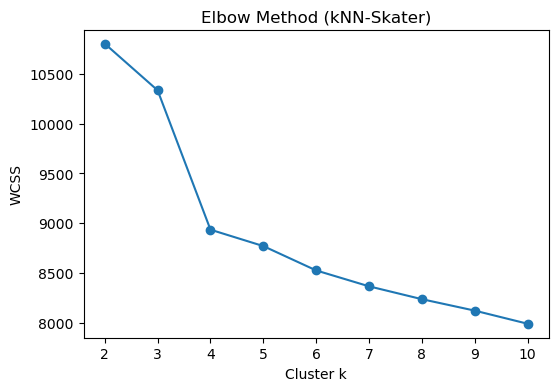

In [58]:
def compute_wcss(gdf, attrs, w, k_range):
    wcss = []
    data_arr = gdf[attrs].values
    for k in k_range:
        model = Skater(
            gdf,
            w,
            attrs, 
            n_clusters=k,
            floor=0.05
        )
        model.solve()
        labels = model.labels_
        # 计算每簇的平方和
        wss_k = 0
        for i in range(k):
            pts = data_arr[labels == i]
            if pts.size:
                cent = pts.mean(axis=0)
                wss_k += ((pts - cent)**2).sum()
        wcss.append(wss_k)
    return wcss

k_range = range(2, 11)
wcss = compute_wcss(gdf_std, std_cols, w, k_range)
plt.figure(figsize = (6,4))
plt.plot(list(k_range), wcss, 'o-')
plt.xlabel('Cluster k')
plt.ylabel('WCSS')
plt.title('Elbow Method (kNN‐Skater)')
plt.show()

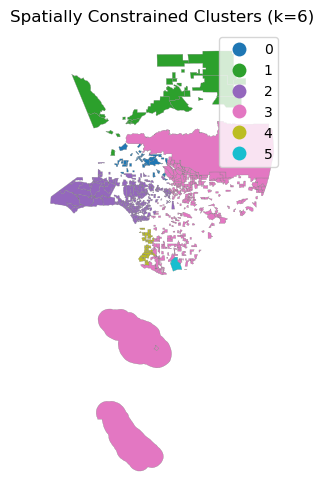

In [71]:
n_clusters = 6
model = Skater(
    gdf_std,
    w, 
    std_cols,
    n_clusters = n_clusters,
    floor = 0.05
)
model.solve()

gdf_std['cluster'] = model.labels_

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf_std.plot(
    column = 'cluster',
    categorical = True,
    legend = True,
    linewidth = 0.2,
    edgecolor = 'gray',
    ax = ax
)
ax.set_axis_off()
ax.set_title(f"Spatially Constrained Clusters (k={n_clusters})")
plt.show()

# descriptive table
- 按照这届个cluster整理sensors的分布信息

In [63]:
gdf_std

,GEOID,max_active,min_active,days_with_activity,total_active,avg_daily_sensors,DP05_0001E,male_rate,hispanic_rate,white_rate,...,25_older_rate_std,S1101_C01_001E_std,S1101_C01_002E_std,S1101_C01_005E_std,B25034_001E_std,pct_built_pre1979_std,pct_built_1980_2000_std,pct_built_after2000_std,S1501_C01_012E_std,cluster
0,06037101110,1,1,133,133,0.174770,3879.0,0.501160,0.259087,0.594225,...,0.650317,-0.030835,0.040096,-0.266229,-0.011310,0.298967,-0.150969,-0.300490,-0.500948,0
1,06037101300,1,1,87,87,0.114323,4068.0,0.472222,0.147493,0.750983,...,0.790786,-0.150493,0.040096,-0.040324,-0.186097,-0.176895,0.495380,-0.272866,-0.287843,0
2,06037102107,1,1,660,660,0.867280,3920.0,0.478571,0.196429,0.641837,...,0.504897,-0.499766,0.040096,-0.635893,-0.585816,0.075596,-0.067620,-0.043299,-0.157498,0
3,06037103101,1,1,625,625,0.821288,2481.0,0.533253,0.266022,0.629988,...,0.495739,-0.967081,0.040096,-0.784786,-0.959746,0.545266,-0.718301,-0.056423,-0.730605,0
4,06037103202,1,1,650,650,0.854139,2082.0,0.506244,0.226705,0.544188,...,0.871603,-1.379417,0.040096,-1.436831,-1.356600,0.856926,-1.140433,-0.075832,-1.283021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,06037980015,2,1,621,683,0.897503,1028.0,0.529183,0.357004,0.042802,...,-0.678741,-1.670478,0.040096,-1.277671,-1.625944,-1.769035,0.074664,2.686632,-1.454746,6
623,06037980017,2,1,347,445,0.584757,1075.0,0.789767,0.184186,0.375814,...,1.501958,-2.385195,0.040096,-1.785958,-2.276383,0.320600,-1.140433,0.763809,-1.599575,2
624,06037980024,1,1,205,205,0.269382,200.0,0.500000,0.205000,0.530000,...,-0.959960,-2.314046,0.040096,-1.837300,-2.241998,0.535245,-0.714200,-0.045286,-1.645092,2
625,06037980025,1,1,2,2,0.002628,444.0,0.432432,0.000000,0.000000,...,0.160359,-2.086049,0.040096,-1.606261,-2.039990,0.638227,-0.262737,-0.707569,-1.570609,5


In [67]:
mapping = {
    'max_active': ('Active Sensors', 'Max Active'),
    'min_active': ('Active Sensors', 'Min Active'),
    'days_with_activity': ('Active Sensors',  'Active Days'),
    'avg_daily_sensors':  ('Active Sensors', 'Avg Daily Active Sensors'),
    'DP05_0001E': ('Population', 'count (DP05_0001E)'),
    'male_rate':  ('Gender', 'Male Rate'),
    'hispanic_rate': ('Race/ Ethnicity', 'Hispanic/ Latino'),
    'white_rate':  ('Race/ Ethnicity', 'White'),
    'black_rate': ('Race/ Ethnicity', 'Black Or African American'),
    'native_american_rate': ('Race/ Ethnicity',  'American Indian and Alaska Native'),
    'asian_rate':  ('Race/ Ethnicity', 'Asian'),
    'pacific_islander_rate': ('Race/ Ethnicity',  'Native Hawaiian and Other Pacific Islander'),
    'other_race_rate': ('Race/ Ethnicity', 'Others'),
    '25_older_rate': ('Age', 'Age > 25 (%)'),
    'S1501_C01_012E': ('Poverty', 'Median HH income (S1501_C01_012E)'),
    'pct_built_pre1979': ('Structure Built year', 'Pre 1979 (%)'),
    'pct_built_1980_2000': ('Structure Built year', '1980 - 1999 (%)'),
    'pct_built_after2000': ('Structure Built year', 'Post 2000 (%)'),
}
df = gdf_std[ list(mapping.keys()) + ['cluster'] ]
df_mean = df.groupby('cluster').mean()
df_std  = df.groupby('cluster').std()
df_fmt = df_mean.round(2).astype(str) + ' (' + df_std.round(2).astype(str) + ')'
df_fmt = df_fmt.T
tuples = [ mapping[col] for col in mapping.keys() ]
row_index = pd.MultiIndex.from_tuples(tuples, names=['Category','Variable'])
df_fmt.index = row_index
df_fmt.columns = [f'Cluster {c}' for c in df_fmt.columns]

counts = df['cluster'].value_counts().sort_index()
df_count = counts.to_frame().T
df_count.index = pd.MultiIndex.from_tuples(
    [('Tract', 'Number of tracts')],
    names=['Category','Variable']
)
df_count.columns = [f'Cluster {c}' for c in df_count.columns]
df_final = pd.concat([df_count, df_fmt], axis=0)

print(df_final)
df_final.to_csv('../Data/Output/descriptive_table.csv')

                                                                       Cluster 0  \
Category             Variable                                                      
Tract                Number of tracts                                         45   
Active Sensors       Max Active                                      1.27 (0.45)   
                     Min Active                                        1.0 (0.0)   
                     Active Days                                 406.82 (236.56)   
                     Avg Daily Active Sensors                        0.61 (0.38)   
Population           count (DP05_0001E)                          3838.8 (1048.9)   
Gender               Male Rate                                        0.5 (0.04)   
Race/ Ethnicity      Hispanic/ Latino                                0.53 (0.32)   
                     White                                           0.32 (0.26)   
                     Black Or African American                       0.02 (0

- 收入越高（Cluster 2, 3, 8），传感器活跃天数与每日活跃数往往也更高。
- 低收入且西裔占主导（Cluster 0, 5）中，传感器活跃度和覆盖面较弱。
- 住宅年代老旧（Pre 1979 > 75 %）几乎遍布各簇，但新开发量明显高的只有 Cluster 1（Post 2000 ≈ 29 %）。